<a href="https://colab.research.google.com/github/Cristobalm26/Actividades_EIE401/blob/main/Actividades/Proyecto_2/Proyecto_2_Crist%C3%B3bal_Moraga_19_841_682_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Cristóbal Antonio Moraga Acosta</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
from skimage.metrics import structural_similarity as ssim

In [7]:
# ruta de los templates
ruta_imagen_box = '/content/drive/MyDrive/Colab Notebooks/box_templae.png'
ruta_imagen_circ = '/content/drive/MyDrive/Colab Notebooks/circ_templae.png'
ruta_imagen_cross = '/content/drive/MyDrive/Colab Notebooks/cross_templae.png'

In [8]:
# Templates
template_box = cv2.imread(ruta_imagen_box)
template_circ = cv2.imread(ruta_imagen_circ)
template_cross = cv2.imread(ruta_imagen_cross)

In [9]:
# Imagenes en color
template_box1 = cv2.cvtColor(template_box, cv2.COLOR_BGR2RGB)
template_circ1 = cv2.cvtColor(template_circ, cv2.COLOR_BGR2RGB)
template_cross1 = cv2.cvtColor(template_cross, cv2.COLOR_BGR2RGB)

# Imagenes en escala de grises
template_box_gris = cv2.cvtColor(template_box1, cv2.COLOR_BGR2GRAY)
template_circ_gris = cv2.cvtColor(template_circ1, cv2.COLOR_BGR2GRAY)
template_cross_gris = cv2.cvtColor(template_cross1, cv2.COLOR_BGR2GRAY)

In [10]:
# dimensiones de los templates
w, h = template_box_gris.shape[::-1]
t, u = template_circ_gris.shape[::-1]
v, z = template_cross_gris.shape[::-1]
print(w)
print(h)
print(t)
print(u)
print(v)
print(z)

16
16
16
16
16
16


In [12]:
# Ruta al archivo ZIP en Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/imagenes.zip'

# Directorio para extraer los archivos
output_dir = '/content/Imagenes_ZIP4'
os.makedirs(output_dir, exist_ok=True)

# Extraer el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("Extracción completada.")


Extracción completada.


In [15]:
# Carga de datos del archivo.zip
input_dir = '/content/Imagenes_ZIP4/processed512'
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [17]:
# Clasificar las imágenes
classified_images = {"cross": [], "box": [], "circ": []}
template_labels = ['box', 'circ', 'cross']

# Resultados de la clasificación
results = []

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [18]:
# Funcion SQDIFF
def test(img, template):
    result = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)
    return result

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

![image.png](attachment:6850d57c-7e6f-4acf-ac3b-d9a8feb071cb.png)

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

Primero se toma una sola imagen para hacer el matching

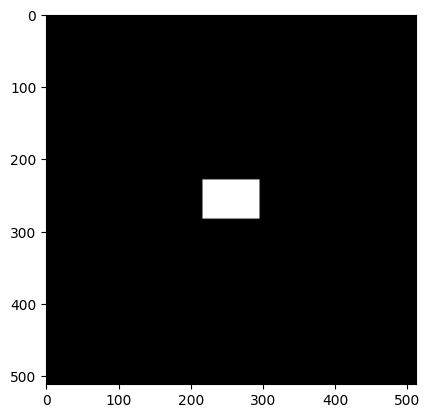

La imagen se parece más al template: box


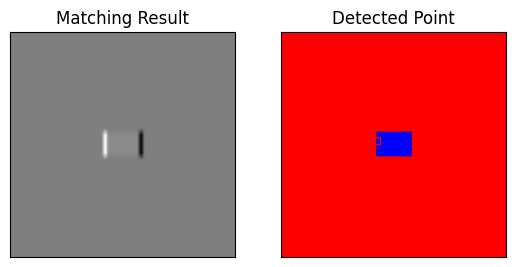

In [24]:
ruta_img = '/content/Imagenes_ZIP4/processed512/box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-0_80-90.png'
img = cv2.imread(ruta_img)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gris, cmap='gray')
plt.show()

# Aplicando template Matching
res = cv2.matchTemplate(img_gris,template_box_gris,cv2.TM_SQDIFF)
res2 = cv2.matchTemplate(img_gris,template_circ_gris,cv2.TM_SQDIFF)
res3 = cv2.matchTemplate(img_gris,template_cross_gris,cv2.TM_SQDIFF)
# minimos y maximos valores
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(res2)
min_val3, max_val3, min_loc3, max_loc3 = cv2.minMaxLoc(res3)

# Determinando cual template tiene el valor mas alto
max_values = [max_val, max_val2, max_val3]
templates_labels = ['box', 'circ', 'cross']
best_match_index = np.argmax(max_values)
best_match_label = templates_labels[best_match_index]

print(f"La imagen se parece más al template: {best_match_label}")

# Visualización de los resultados
top_left = [max_loc, max_loc2, max_loc3][best_match_index]
bottom_right = [
    (top_left[0] + w, top_left[1] + h),
    (top_left[0] + t, top_left[1] + u),
    (top_left[0] + v, top_left[1] + z)
][best_match_index]

cv2.rectangle(img, top_left, bottom_right, 255, 2)

plt.subplot(121), plt.imshow([res, res2, res3][best_match_index], cmap='gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img, cmap='gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.show()

Ahora se escala lo anterior y se hace iterativo para que se lean todos las imagenes del archivo .zip

In [19]:
start = timer()
# Procesar cada imagen en el directorio
for image_file in image_files:
    # Leer la imagen
    img_path = os.path.join(input_dir, image_file)
    img_gris = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Calcular SQDIFF para cada template
    ncc_box = test(img_gris, template_box_gris)
    ncc_circ = test(img_gris, template_circ_gris)
    ncc_cross = test(img_gris, template_cross_gris)

    # Obtener los valores máximos
    _, max_val, _, _ = cv2.minMaxLoc(ncc_box)
    _, max_val2, _, _ = cv2.minMaxLoc(ncc_circ)
    _, max_val3, _, _ = cv2.minMaxLoc(ncc_cross)

    # Determinar la mejor coincidencia
    max_values = [max_val, max_val2, max_val3]
    best_match_index = np.argmax(max_values)
    best_match_label = template_labels[best_match_index]

    # Clasificar la imagen
    classified_images[best_match_label].append(image_file)
    results.append((image_file, best_match_label))

    #print(f"La imagen {image_file} se parece más al template: {best_match_label}")

# Calcular el error de clasificación
true_labels = [f.split('_')[0] for f in image_files]
pred_labels = [result[1] for result in results]

conf_matrix = confusion_matrix(true_labels, pred_labels, labels=template_labels)
accuracy = accuracy_score(true_labels, pred_labels)
error_rate = 1 - accuracy
end = timer()
print('matching ejecutado')

matching ejecutado


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.



Ejemplos Clasificados Correctamente:
Imagen: cross_01_freq_reflect_e9503ad7-c681-11ee-809f-047c16a08772_0-477_80-90.png, Clasificación: cross
Imagen: circ_01_freq_reflect_56dee422-b317-11ee-bb58-047c16a08772_0-1287_80-90.png, Clasificación: circ

Ejemplos Clasificados Incorrectamente:
Imagen: cross_01_freq_reflect_8079ceb8-e14d-11ee-9a7b-047c16a08772_0-140_80-90.png, Clasificación: circ
Imagen: cross_01_freq_reflect_3be7fd33-bd16-11ee-be43-047c16a08772_0-841_80-90.png, Clasificación: box

Imágenes Clasificadas Correctamente:


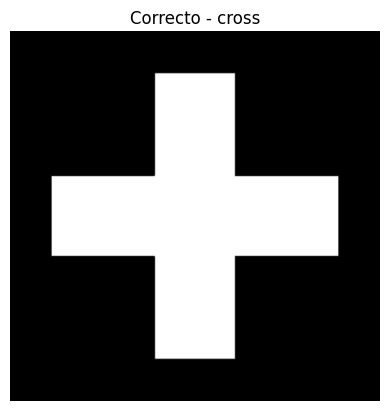

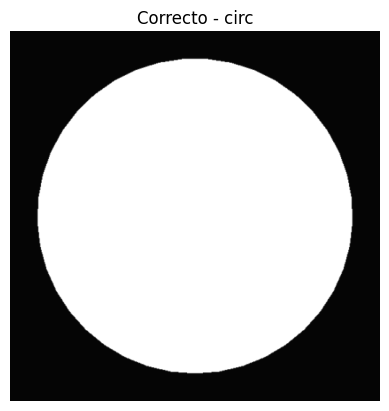


Imágenes Clasificadas Incorrectamente:


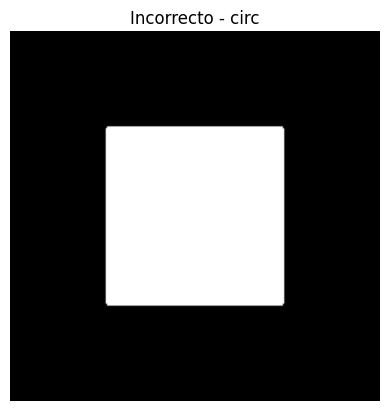

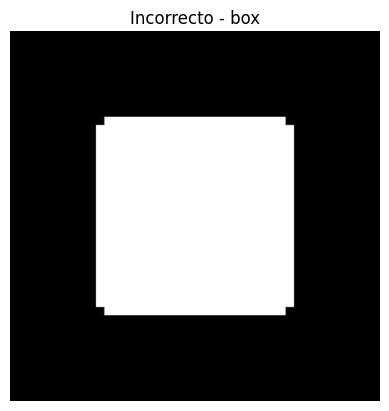

In [20]:
# Mostrar ejemplos de imágenes clasificadas correctamente e incorrectamente
correct_examples = [result for result in results if result[0].split('_')[0] == result[1]]
incorrect_examples = [result for result in results if result[0].split('_')[0] != result[1]]

print("\nEjemplos Clasificados Correctamente:")
for example in correct_examples[:2]:
    print(f"Imagen: {example[0]}, Clasificación: {example[1]}")

print("\nEjemplos Clasificados Incorrectamente:")
for example in incorrect_examples[:2]:
    print(f"Imagen: {example[0]}, Clasificación: {example[1]}")

# Mostrar algunas imágenes clasificadas correctamente e incorrectamente
def display_image(image_file, label, title):
    img_path = os.path.join(input_dir, image_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f'{title} - {label}')
    plt.axis('off')
    plt.show()

print("\nImágenes Clasificadas Correctamente:")
for example in correct_examples[:2]:
    display_image(example[0], example[1], 'Correcto')

print("\nImágenes Clasificadas Incorrectamente:")
for example in incorrect_examples[:2]:
    display_image(example[0], example[1], 'Incorrecto')

In [21]:
print(f"\nMatriz de Confusión:\n{conf_matrix}")
print(f"Precisión: {accuracy:.2f}")
print(f"Tasa de Error: {error_rate:.2f}")


Matriz de Confusión:
[[3875  114    0]
 [   0 4416    0]
 [ 845   57 5021]]
Precisión: 0.93
Tasa de Error: 0.07


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [22]:
print(end - start)

340.40291243499996
